In [ ]:
# random_fields.py

import torch
import math

class GaussianRF(object):
    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic", device=None):
        self.dim = dim
        self.device = device

        print(f"Class GaussianRF has input dims={self.dim} and using device {self.device}")

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size // 2

        if dim == 1:
            k = torch.cat((torch.arange(0, k_max, device=device), 
                           torch.arange(-k_max, 0, device=device)), 0)

            self.sqrt_eig = size * math.sqrt(2.0) * sigma * ((4 * (math.pi**2) * (k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0

        elif dim == 2:
            wavenumbers = torch.cat((torch.arange(0, k_max, device=device), 
                                     torch.arange(-k_max, 0, device=device)), 0).repeat(size, 1)

            k_x = wavenumbers.transpose(0, 1)
            k_y = wavenumbers

            self.sqrt_eig = size**2 * math.sqrt(2.0) * sigma * ((4 * (math.pi**2) * (k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0, 0] = 0.0

        elif dim == 3:
            wavenumbers = torch.cat((torch.arange(0, k_max, device=device), 
                                     torch.arange(-k_max, 0, device=device)), 0).repeat(size, size, 1)

            k_x = wavenumbers.transpose(1, 2)
            k_y = wavenumbers
            k_z = wavenumbers.transpose(0, 2)

            self.sqrt_eig = size**3 * math.sqrt(2.0) * sigma * ((4 * (math.pi**2) * (k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0, 0, 0] = 0.0

        self.size = (size,) * dim

    def sample(self, N):
        # Create random coefficients with the appropriate size
        coeff = torch.randn(N, *self.size, 2, device=self.device)

        # Apply the square root of the eigenvalues to the coefficients
        coeff[..., 0] *= self.sqrt_eig
        coeff[..., 1] *= self.sqrt_eig

        # Convert to real space using multi-dimensional inverse FFT
        print("Converting To Real Space")
        u = torch.fft.ifftn(torch.view_as_complex(coeff), s=self.size, dim=list(range(1, self.dim + 1)))
        u = u.real  # Extract the real part after inverse FFT

        return u

In [23]:
# ns_2d.py

import torch
import math
import matplotlib.pyplot as plt
import matplotlib
# from random_fields import GaussianRF
from timeit import default_timer
import scipy.io


def navier_stokes_2d(w0, f, visc, T, delta_t=1e-4, record_steps=1):
    '''
    Parameters:
        w0: initial vorticity
        f: forcing term
        visc: viscosity (1/Re)
        T: final time
        delta_t: internal time-step for solve (decrease if blow-up)
        record_steps: number of in-time snapshots to record
    '''
    # Grid size - must be power of 2
    N = w0.size()[-1]

    # Maximum frequency
    k_max = math.floor(N/2.0)

    # Number of steps to final time
    steps = math.ceil(T/delta_t)

    # Initial vorticity to Fourier space
    w_h = torch.fft.fft2(w0)

    # Forcing to Fourier space
    f_h = torch.fft.fft2(f)

    # If same forcing for the whole batch
    if len(f_h.size()) < len(w_h.size()):
        f_h = f_h.unsqueeze(0)

    # Record solution every this number of steps
    record_time = math.floor(steps/record_steps)

    # Wavenumbers in y-direction
    k_y = torch.cat(
        (
            torch.arange(0, k_max, device=w0.device),
            torch.arange(-k_max, 0, device=w0.device)
        ),
        0
    ).repeat(N, 1)
    # Wavenumbers in x-direction
    k_x = k_y.transpose(0, 1)

    # Negative Laplacian in Fourier space
    lap = 4 * (math.pi ** 2) * (k_x ** 2 + k_y ** 2)
    lap[0, 0] = 1.0  # Avoid division by zero
    lap = lap.unsqueeze(0)  # For broadcasting

    # Dealiasing mask
    dealias = (
        (torch.abs(k_y) <= (2.0 / 3.0) * k_max)
        & (torch.abs(k_x) <= (2.0 / 3.0) * k_max)
    ).float()
    dealias = dealias.unsqueeze(0)  # For broadcasting

    # Saving solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=w0.device)
    sol_t = torch.zeros(record_steps, device=w0.device)

    # Record counter
    c = 0
    # Physical time
    t = 0.0
    for j in range(steps):
        # Stream function in Fourier space: solve Poisson equation
        psi_h = w_h / lap

        # Velocity field in x-direction = psi_y
        q_h = (1j) * 2 * math.pi * k_y * psi_h
        q = torch.fft.ifft2(q_h).real

        # Velocity field in y-direction = -psi_x
        v_h = (-1j) * 2 * math.pi * k_x * psi_h
        v = torch.fft.ifft2(v_h).real

        # Partial x of vorticity
        w_x_h = (1j) * 2 * math.pi * k_x * w_h
        w_x = torch.fft.ifft2(w_x_h).real

        # Partial y of vorticity
        w_y_h = (1j) * 2 * math.pi * k_y * w_h
        w_y = torch.fft.ifft2(w_y_h).real

        # Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F = q * w_x + v * w_y
        F_h = torch.fft.fft2(F)
        # Dealias
        F_h = dealias * F_h

        # Crank-Nicolson update
        denom = 1.0 + 0.5 * delta_t * visc * lap
        numer = (
            -delta_t * F_h
            + delta_t * f_h
            + (1.0 - 0.5 * delta_t * visc * lap) * w_h
        )
        w_h = numer / denom

        # Update real time (used only for recording)
        t += delta_t

        if (j + 1) % record_time == 0:
            # Solution in physical space
            w = torch.fft.ifft2(w_h).real

            # Record solution and time
            sol[..., c] = w
            sol_t[c] = t

            c += 1

    return sol, sol_t


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Runnig on Device", device)

# Resolution
s = 256

# Number of solutions to generate
N = 20

# Set up 2d GRF with covariance parameters
GRF = GaussianRF(2, s, alpha=2.5, tau=7, device=device)

# Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
t_space = torch.linspace(0, 1, s + 1, device=device)[:-1]
X, Y = torch.meshgrid(t_space, t_space, indexing='ij')
f = 0.1 * (torch.sin(2 * math.pi * (X + Y)) + torch.cos(2 * math.pi * (X + Y)))

# Number of snapshots from solution
record_steps = 200

# Inputs
a = torch.zeros(N, s, s, device=device)
# Solutions
u = torch.zeros(N, s, s, record_steps, device=device)

# Solve equations in batches

# Batch size
bsize = 20

c = 0
t0 = default_timer()
for j in range(N // bsize):
    print("Inside the loop")
    # Sample random fields
    w0 = GRF.sample(bsize)

    # Solve NS
    sol, sol_t = navier_stokes_2d(w0, f, 1e-3, 50.0, 1e-4, record_steps)

    a[c:(c + bsize), ...] = w0
    u[c:(c + bsize), ...] = sol

    c += bsize
    t1 = default_timer()
    print(j, c, t1 - t0)

# Save data
print("Saving Files...")
scipy.io.savemat(f'ns_data_R{S}_S{N}.mat', {
    'a': a.cpu().numpy(),
    'u': u.cpu().numpy(),
    't': sol_t.cpu().numpy()
})

print(f"Created Data with solutions={N} and resolution={S}")

True
cuda
20
Inside the loop
0 20 1873.261168738827
Saving Files


In [25]:
# utilities3.py

import torch
import numpy as np
import scipy.io
import h5py
import sklearn.metrics
import torch.nn as nn
from scipy.ndimage import gaussian_filter


#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x

Hyperparameters 500 0.0025 100 0.5
torch.Size([16, 64, 64, 10])
torch.Size([4, 64, 64, 10])
preprocessing finished, time used: 8.454503908753395
Number of model parameters: 465717
Epoch 0, Time: 7.08s, Train Loss: 0.731228, Test Loss: 0.675947
Epoch 1, Time: 6.38s, Train Loss: 0.361151, Test Loss: 0.553826
Epoch 2, Time: 7.17s, Train Loss: 0.360371, Test Loss: 0.319182
Epoch 3, Time: 7.74s, Train Loss: 0.270712, Test Loss: 0.263924
Epoch 4, Time: 5.97s, Train Loss: 0.251010, Test Loss: 0.324592
Epoch 5, Time: 5.68s, Train Loss: 0.213644, Test Loss: 0.274859
Epoch 6, Time: 6.64s, Train Loss: 0.183206, Test Loss: 0.297910
Epoch 7, Time: 7.67s, Train Loss: 0.162097, Test Loss: 0.245684
Epoch 8, Time: 6.56s, Train Loss: 0.167181, Test Loss: 0.280634
Epoch 9, Time: 6.25s, Train Loss: 0.131740, Test Loss: 0.229516
Epoch 10, Time: 6.50s, Train Loss: 0.130791, Test Loss: 0.271938
Epoch 11, Time: 6.80s, Train Loss: 0.145580, Test Loss: 0.251441
Epoch 12, Time: 7.14s, Train Loss: 0.118665, Test 

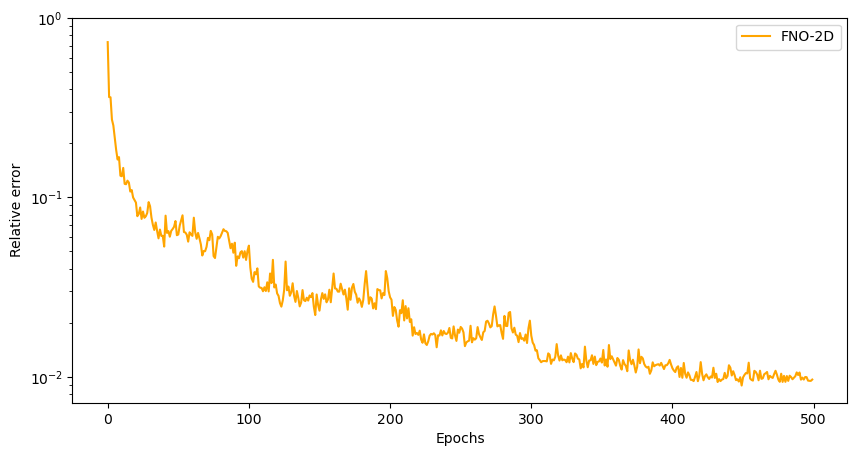

<Figure size 640x480 with 0 Axes>

In [30]:
# fourier_2d_rnn.py

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
# from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io

torch.manual_seed(0)
np.random.seed(0)


class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()
        """
        2D Fourier layer. It does FFT, linear transform, and inverse FFT.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes1 (int): Number of Fourier modes to keep along the first dimension.
            modes2 (int): Number of Fourier modes to keep along the second dimension.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        # Performs complex multiplication of the input and weights
        # input: (batch, in_channel, x, y), complex tensor
        # weights: (in_channel, out_channel, x, y), complex tensor
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x, norm='ortho')

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)

        # First modes
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights1
        )

        # Negative modes
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1:, :self.modes2], self.weights2
        )

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)), norm='ortho')
        return x


class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(SimpleBlock2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(12, self.width)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)  # (batch, channels, x, y)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn0(x1 + x2)
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn1(x1 + x2)
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn2(x1 + x2)
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn3(x1 + x2)

        x = x.permute(0, 2, 3, 1)  # (batch, x, y, channels)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        self.conv1 = SimpleBlock2d(modes, modes, width)

    def forward(self, x):
        x = self.conv1(x)
        return x

    def count_params(self):
        c = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return c
        

TRAIN_PATH = 'ns_data_R256_S20.mat'
TEST_PATH = 'ns_data_R256_S20.mat'

ntrain = 16
ntest = 4

modes = 12
width = 20

batch_size = 4

epochs = 500
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

print("Hyperparameters", epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'ns_fourier_2d_rnn_V10000_T20_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

runtime = np.zeros(2, )
t1 = default_timer()

sub = 4
S = 64
T_in = 10
T = 10
step = 1


################################################################
# Load data
################################################################

reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain, ::sub, ::sub, :T_in]
train_u = reader.read_field('u')[:ntrain, ::sub, ::sub, T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:, ::sub, ::sub, :T_in]
test_u = reader.read_field('u')[-ntest:, ::sub, ::sub, T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain, S, S, T_in)
test_a = test_a.reshape(ntest, S, S, T_in)

# Pad the location (x, y)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1).repeat([1, 1, S, 1])
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1).repeat([1, S, 1, 1])

train_a = torch.cat((gridx.repeat([ntrain, 1, 1, 1]), gridy.repeat([ntrain, 1, 1, 1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest, 1, 1, 1]), gridy.repeat([ntest, 1, 1, 1]), test_a), dim=-1)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False
)

t2 = default_timer()

print('preprocessing finished, time used:', t2 - t1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


################################################################
# Training and evaluation
################################################################

model = Net2d(modes, width).to(device)
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print("Number of model parameters:", model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
gridx = gridx.to(device)
gridy = gridy.to(device)

# Initialize lists to store losses
train_losses = []
test_losses = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)
        current_batch_size = xx.shape[0]

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(current_batch_size, -1), y.reshape(current_batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat(
                (
                    xx[..., step:-2],
                    im,
                    gridx.repeat([current_batch_size, 1, 1, 1]),
                    gridy.repeat([current_batch_size, 1, 1, 1])
                ),
                dim=-1
            )

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(current_batch_size, -1), yy.reshape(current_batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Record the average training loss for this epoch
    avg_train_loss = train_l2_full / ntrain
    train_losses.append(avg_train_loss)

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        model.eval()
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)
            current_batch_size = xx.shape[0]

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(current_batch_size, -1), y.reshape(current_batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat(
                    (
                        xx[..., step:-2],
                        im,
                        gridx.repeat([current_batch_size, 1, 1, 1]),
                        gridy.repeat([current_batch_size, 1, 1, 1])
                    ),
                    dim=-1
                )

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(current_batch_size, -1), yy.reshape(current_batch_size, -1)).item()

    # Record the average testing loss for this epoch
    avg_test_loss = test_l2_full / ntest
    test_losses.append(avg_test_loss)

    t2 = default_timer()
    scheduler.step()
    print(
        f"Epoch {ep}, Time: {t2 - t1:.2f}s, "
        f"Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}"
    )


# # After training, plot the losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(epochs), train_losses, label='FNO-2D', color='orange')
# # plt.plot(range(epochs), test_losses, label='Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Relative error')
# # plt.title('Error vs. Epochs')
# plt.legend()
# # plt.grid(True)
# plt.show()
# plt.savefig('fno_2d_rnn.png')

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='FNO-2D', color='orange')
# plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Relative error')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Optional: Set custom y-axis ticks (optional)
plt.yticks([10**i for i in range(-2, 1)])

# plt.title('Error vs. Epochs')
plt.legend()
# plt.grid(True)
plt.show()

# Save the plot
plt.savefig('fno_2d_rnn.png')


# Saving the trained model
torch.save(model.state_dict(), path_model + '.pth')


# ################################################################
# # Generating and Saving Predictions
# ################################################################

# predictions = []
# test_l2 = 0.0
# with torch.no_grad():
#     model.eval()
#     for xx, yy in test_loader:
#         xx = xx.to(device)
#         yy = yy.to(device)

#         pred = model(xx)
#         predictions.append(pred.cpu())
#         test_l2 += myloss(pred.reshape(pred.size(0), -1), yy.to(device).reshape(pred.size(0), -1)).item()

# # Concatenate all predictions
# predictions = torch.cat(predictions, dim=0)  # Shape: (ntest, S, S, 1)

# # Save predictions as a PyTorch tensor
# torch.save({'predictions': predictions}, 'predictions.pt')

# # Optionally, save predictions in .mat format if needed
# scipy.io.savemat('pred/' + path + '.mat', {'pred': predictions.numpy()})


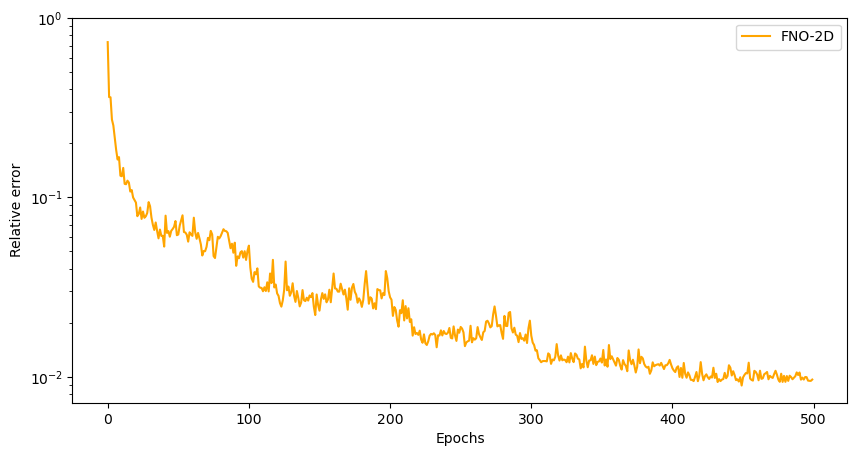

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='FNO-2D', color='orange')
# plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Relative error')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Optional: Set custom y-axis ticks (optional)
plt.yticks([10**i for i in range(-2, 1)])

# plt.title('Error vs. Epochs')
plt.legend()
# plt.grid(True)
plt.show()